# Take home challenge #2: Relax


### Preparation of Google Codelab environment

In [1]:
#Mount google drive as your hardisk
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Path for Colab
PROJECT_PATH = './drive/My Drive/Springboard/Take_home_assignment_2/relax_challenge/'

# Instructions from the assigment

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven­day period , identify which factors predict future user
adoption .

We suggest spending 1­-2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better ­­ no more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

### Load the data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import pickle
import datetime as dt

In [0]:
FILE = 'takehome_users.csv'
users_df = pd.read_csv(PROJECT_PATH + FILE, infer_datetime_format = True, encoding = 'Latin')

In [5]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [7]:
users_df.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6.000500e+03,3.464246e+03,1.000000e+00,3.000750e+03,6.000500e+03,9.000250e+03,1.200000e+04
last_session_creation_time,8823.0,1.379279e+09,1.953116e+07,1.338452e+09,1.363195e+09,1.382888e+09,1.398443e+09,1.402067e+09
opted_in_to_mailing_list,12000.0,2.495000e-01,4.327417e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
enabled_for_marketing_drip,12000.0,1.493333e-01,3.564316e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
org_id,12000.0,1.418846e+02,1.240567e+02,0.000000e+00,2.900000e+01,1.080000e+02,2.382500e+02,4.160000e+02
invited_by_user_id,6417.0,5.962957e+03,3.383762e+03,3.000000e+00,3.058000e+03,5.954000e+03,8.817000e+03,1.199900e+04


In [0]:
FILE = 'takehome_user_engagement.csv'
eng_df = pd.read_csv(PROJECT_PATH + FILE, infer_datetime_format = True, encoding = 'Latin')

In [9]:
eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
eng_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,207917.0,5913.314197,3394.941674,1.0,3087.0,5682.0,8944.0,12000.0
visited,207917.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


### Find out if customer is active 
"user who has logged into the product on three separate days in at least one seven­day period"


In [0]:
eng_df['time_stamp'] = pd.to_datetime(eng_df['time_stamp'])
eng_df.set_index('time_stamp', inplace = True, drop = True)

In [13]:
eng_df.head(3)

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1


In [0]:
def adopted(df):
  
  df_res = df.visited.resample('D').count()
  df_res.loc[df_res.values >1] =1
  x = df_res.rolling(7).sum().fillna(0).values
  return (x >= 3).any()

In [0]:
def days_accessed_time_interval(df, time_interval):
  
  df_res = df.visited.resample('D').count()
  df_res.loc[df_res.values >1] =1
  if df_res.size == 0:
    return False

  start_date = df_res.index[0]
  end_date = start_date + dt.timedelta(days = time_interval)
  df_res = df_res.loc[(df_res.index >= start_date) & (df_res.index<end_date)]
  x = df_res.rolling(7).sum().fillna(0).values
  return int(x.sum())

In [0]:
# Note: Good test with user_id 3623
user_ids = users_df.object_id.values
for id in user_ids:
  mini_df = eng_df.loc[eng_df.user_id == id]
  users_df.loc[users_df.object_id == id, 'adopted'] = adopted(mini_df)
  users_df.loc[users_df.object_id == id, 'days_accessed_first_week'] = days_accessed_time_interval(mini_df,7)
  users_df.loc[users_df.object_id == id, 'days_accessed_first_month'] = days_accessed_time_interval(mini_df, 30)
  users_df.loc[users_df.object_id == id, 'days_accessed_first_3_months'] = days_accessed_time_interval(mini_df, 90)
  users_df.loc[users_df.object_id == id, 'days_accessed_first_6_months'] = days_accessed_time_interval(mini_df, 180)

In [18]:
users_df.groupby('adopted').count()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,days_accessed_first_week,days_accessed_first_month,days_accessed_first_3_months,days_accessed_first_6_months
adopted,,,,,,,,,,,,,,
False,10403,10403,10403,10403,10403,7226,10403,10403,10403,5506,10403,10403,10403,10403
True,1597,1597,1597,1597,1597,1597,1597,1597,1597,911,1597,1597,1597,1597


In [19]:
users_df.head(1)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,days_accessed_first_week,days_accessed_first_month,days_accessed_first_3_months,days_accessed_first_6_months
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,0,0,0,0


### Feature engineering


In [0]:
# extraction creation time year, month, day and hour
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time_2'] = pd.to_datetime(users_df['last_session_creation_time'], unit = 's')

In [0]:
users_df['days_from_creation_to_last_session'] = (users_df['last_session_creation_time_2'] - users_df['creation_time']).astype('timedelta64[D]')

In [0]:
users_df['creation_year'] = users_df['creation_time'].dt.year
users_df['creation_month'] = users_df['creation_time'].dt.month
users_df['creation_day'] = users_df['creation_time'].dt.day
users_df['creation_weekday'] = users_df['creation_time'].dt.weekday

In [0]:
# extraction of email domain
users_df['email_domain'] = users_df['email'].str.rsplit('@').str[1]

In [0]:
# extraction of user surname
users_df['surname']=users_df['name'].str.split().str[0]

In [25]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,days_accessed_first_week,days_accessed_first_month,days_accessed_first_3_months,days_accessed_first_6_months,last_session_creation_time_2,days_from_creation_to_last_session,creation_year,creation_month,creation_day,creation_weekday,email_domain,surname
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,0,0,0,0,2014-04-22 03:53:30,0.0,2014,4,22,1,yahoo.com,Clausen
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,1,14,52,86,2014-03-31 03:45:04,136.0,2013,11,15,4,gustr.com,Poole
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,0,0,0,0,2013-03-19 23:14:52,0.0,2013,3,19,1,gustr.com,Bottrill
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,0,0,0,0,2013-05-22 08:09:28,1.0,2013,5,21,1,yahoo.com,Clausen
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,0,0,0,0,2013-01-22 10:14:20,5.0,2013,1,17,3,yahoo.com,Raw


In [26]:
users_df.opted_in_to_mailing_list.unique()

array([1, 0])

In [27]:
users_df.enabled_for_marketing_drip.unique()

array([0, 1])

In [28]:
users_df.org_id.nunique()

417

In [0]:
#create new column has_invitator_adopted
user_ids = users_df.object_id.values
for id in user_ids:
  invitator_id = users_df.loc[users_df.object_id == id, 'invited_by_user_id'].values[0]
  #print(invitator_id)
  if invitator_id == invitator_id:
    invitator_active = users_df.loc[users_df.object_id == invitator_id, 'adopted'].values[0]
 
    if not(invitator_active):
      invitator_active = False
    users_df.loc[users_df.object_id == id, 'has_invitator_adopted'] = invitator_active
  else: 
    users_df.loc[users_df.object_id == id, 'has_invitator_adopted'] = False

In [30]:
users_df.has_invitator_adopted.sum()

1089

### Quick check if the count of user whose invitators adopted is correct

In [0]:
invitators = users_df.invited_by_user_id.unique()

In [32]:
invitators = invitators[~np.isnan(invitators)] # remove nan values form invitators
print('There are {} invitators'.format(len(invitators)))

There are 2564 invitators


In [0]:
invitators_who_adopted = users_df.loc[(users_df.object_id.isin(invitators)) & (users_df.adopted == True),
                                      'object_id'].values

In [34]:
users_df.loc[users_df.invited_by_user_id.isin(invitators_who_adopted), 'object_id'].count()

1089

### Prepare features for ML model

In [35]:
users_df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'days_accessed_first_week', 'days_accessed_first_month',
       'days_accessed_first_3_months', 'days_accessed_first_6_months',
       'last_session_creation_time_2', 'days_from_creation_to_last_session',
       'creation_year', 'creation_month', 'creation_day', 'creation_weekday',
       'email_domain', 'surname', 'has_invitator_adopted'],
      dtype='object')

In [0]:
# Selected features
selected_features = ['creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'days_accessed_first_week', 
       'days_accessed_first_month', 'days_accessed_first_3_months', 
       'days_accessed_first_6_months', 'days_from_creation_to_last_session',
       'creation_year', 'creation_month', 'creation_day', 'creation_weekday',
       'email_domain', 'surname', 'has_invitator_adopted'] 
#last trip data is exclude because it would leak the target label
X = users_df[selected_features].copy()
# Create labels from boolean
y = users_df.adopted*1

In [42]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,days_accessed_first_week,days_accessed_first_month,days_accessed_first_3_months,days_accessed_first_6_months,days_from_creation_to_last_session,creation_year,creation_month,creation_day,creation_weekday,email_domain,surname,has_invitator_adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,0,0,0,0,0.0,2014,4,22,1,yahoo.com,Clausen,0,1,0,0,0,0
1,0,0,1,1,14,52,86,136.0,2013,11,15,4,gustr.com,Poole,0,0,1,0,0,0
2,0,0,94,0,0,0,0,0.0,2013,3,19,1,gustr.com,Bottrill,1,0,1,0,0,0
3,0,0,1,0,0,0,0,1.0,2013,5,21,1,yahoo.com,Clausen,1,1,0,0,0,0
4,0,0,193,0,0,0,0,5.0,2013,1,17,3,yahoo.com,Raw,1,1,0,0,0,0


In [0]:
# make boolean variables 0's and 1's
X['has_invitator_adopted'] *= 1

In [0]:
# make creation_source one-hot encoded
X = pd.get_dummies(X, columns=['creation_source'])

In [43]:
X.email_domain.nunique()

1184

In [0]:
# Frequency encoding 
def frequency_encoder(df, column):
  encoding = df.groupby(column).size()
  encoding = encoding/len(df)
  return df[column].map(encoding)

In [0]:
# frequency of categorical values (org_id, email_domain, surname)
columns = ['org_id', 'email_domain', 'surname']
for c in columns:
  X[c + '_enc'] = frequency_encoder(X, c)

In [0]:
# tranform string categorical values in number encoding
X['email_domain'] = X['email_domain'].astype('category')
X['email_domain'] = X['email_domain'].cat.codes
X['surname'] = X['surname'].astype('category')
X['surname'] = X['surname'].cat.codes

In [47]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,days_accessed_first_week,days_accessed_first_month,days_accessed_first_3_months,days_accessed_first_6_months,days_from_creation_to_last_session,creation_year,creation_month,creation_day,creation_weekday,email_domain,surname,has_invitator_adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_enc,email_domain_enc,surname_enc
0,1,0,11,0,0,0,0,0.0,2014,4,22,1,1112,589,0,1,0,0,0,0,0.006250,0.203917,0.002583
1,0,0,1,1,14,52,86,136.0,2013,11,15,4,306,2535,0,0,1,0,0,0,0.019417,0.098250,0.000500
2,0,0,94,0,0,0,0,0.0,2013,3,19,1,306,347,1,0,1,0,0,0,0.002667,0.098250,0.000167
3,0,0,1,0,0,0,0,1.0,2013,5,21,1,1112,589,1,1,0,0,0,0,0.019417,0.203917,0.002583
4,0,0,193,0,0,0,0,5.0,2013,1,17,3,1112,2610,1,1,0,0,0,0,0.001333,0.203917,0.000167


In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 23 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
days_accessed_first_week              12000 non-null object
days_accessed_first_month             12000 non-null object
days_accessed_first_3_months          12000 non-null object
days_accessed_first_6_months          12000 non-null object
days_from_creation_to_last_session    8823 non-null float64
creation_year                         12000 non-null int64
creation_month                        12000 non-null int64
creation_day                          12000 non-null int64
creation_weekday                      12000 non-null int64
email_domain                          12000 non-null int16
surname                               12000 non-null int16
has_invitator_adopted                 12000 non-null int64
c

In [0]:
# replace nan values with -1
X['days_from_creation_to_last_session'].fillna(-1, inplace = True)

In [50]:
# Downsample majority class
# Separate majority and minority classes
from sklearn.utils import resample

df = pd.concat([X, y], axis = 1)
df_majority = df[df.adopted==0]
df_minority = df[df.adopted==1]
len_minority = len(df_minority)
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len_minority,     # to match minority class
                                 random_state=101) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.adopted.value_counts()

1    1597
0    1597
Name: adopted, dtype: int64

In [0]:
X = df_downsampled.drop('adopted', axis = 1)
y = df_downsampled.adopted

In [0]:
# separate train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.2, random_state=101)

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

rf = RandomForestClassifier(n_estimators = 1000, random_state = 101)
# Train the model on training data
parameters = { 'max_depth' : [3, 5, 8, 10]}
metric = 'accuracy'
clf = GridSearchCV(rf, parameters, scoring = metric, cv=5)
clf.fit(X_train, y_train)
clf_best = clf.best_estimator_ 
score = accuracy_score(clf_best.predict(X_test), y_test)
score_train = accuracy_score(clf_best.predict(X_train), y_train)
best_max_depth_grid = clf.best_params_['max_depth']
print('Best max_depth: {}, resulted score: {} for the held-out test data and {} for the train set'.format(best_max_depth_grid, score, score_train))



Best max_depth: 10, resulted score: 0.9812206572769953 for the held-out test data and 1.0 for the train set


Accuracy: 98.122%
F1 Score: 98.033%
Precision Score: 97.712%
Recall Score: 98.355%


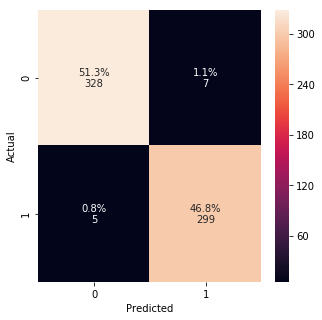

In [54]:
print('Accuracy: {:.3f}%'.format(score*100.0))
y_pred = clf_best.predict(X_test)
print('F1 Score: {:.3f}%'.format(f1_score(y_test, y_pred)*100))
print('Precision Score: {:.3f}%'.format(precision_score(y_test, y_pred)*100))
print('Recall Score: {:.3f}%'.format(recall_score(y_test, y_pred)*100)) 


def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = cm.sum()
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                
                annot[i, j] = '%.1f%%\n%d' % (p, c)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, clf_best.classes_, ymap=None, figsize=(5,5))

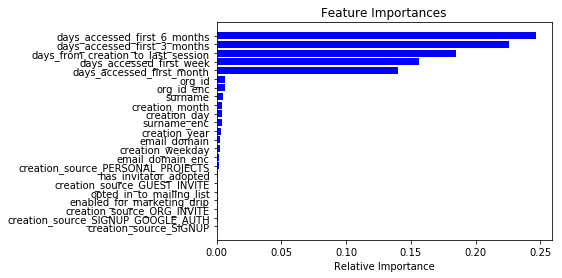

In [55]:
features=X.columns
importances = clf_best.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

#### First conclusion
the feature days_from_creation_to_last_session dominates completly the classification

let's try a model without this feature

In [0]:
columns_to_drop = ['days_accessed_first_month', 'days_accessed_first_3_months',
       'days_accessed_first_6_months', 'days_from_creation_to_last_session']
X2 = X.drop(columns_to_drop, axis=1)

In [0]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
                                    X2, y, test_size=0.2, random_state=101)

In [79]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 101)
# Train the model on training data
parameters = { 'max_depth' : [3, 5, 8, 10]}
metric = 'accuracy'
clf = GridSearchCV(rf, parameters, scoring = metric, cv=5)
clf.fit(X2_train, y2_train)
clf_best = clf.best_estimator_ 
score = accuracy_score(clf_best.predict(X2_test), y2_test)
score_train = accuracy_score(clf_best.predict(X2_train), y2_train)
best_max_depth_grid = clf.best_params_['max_depth']
print('Best max_depth: {}, resulted score: {} for the held-out test data and {} for the train set'.format(best_max_depth_grid, score, score_train))


Best max_depth: 3, resulted score: 0.9655712050078247 for the held-out test data and 0.9565557729941292 for the train set


In [80]:
print('Accuracy: {:.3f}%'.format(score*100.0))
y2_pred = clf_best.predict(X2_test)
print('F1 Score: {:.3f}%'.format(f1_score(y2_test, y2_pred)*100))
print('Precision Score: {:.3f}%'.format(precision_score(y2_test, y2_pred)*100))
print('Recall Score: {:.3f}%'.format(recall_score(y2_test, y2_pred)*100))

Accuracy: 96.557%
F1 Score: 96.508%
Precision Score: 93.252%
Recall Score: 100.000%


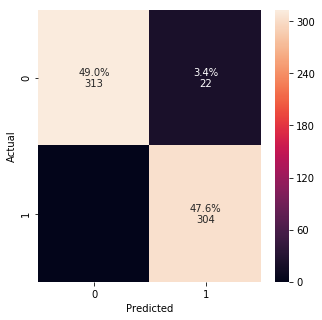

In [81]:
cm_analysis(y2_test, y2_pred, clf_best.classes_, ymap=None, figsize=(5,5))

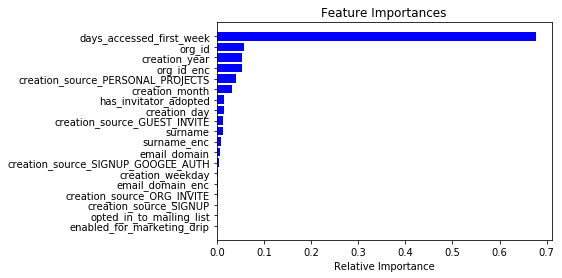

In [82]:
features=X2.columns
importances = clf_best.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [78]:
!pip install shap

     |████████████████████████████████| 245kB 9.5MB/s 
  Created wheel for shap: filename=shap-0.30.1-cp36-cp36m-linux_x86_64.whl size=360446 sha256=27f2139894dd583d1e308a7b41d7e6c96874da73e1ecc133885272f5b5236f19
  Stored in directory: /root/.cache/pip/wheels/62/94/5e/feb9af12d63a719a32266a29ca564b4dc37b4755052aca6859
Successfully built shap


In [0]:
import shap

In [0]:
explainerRF = shap.TreeExplainer(clf_best)
shap_values_RF_test = explainerRF.shap_values(X2_test)

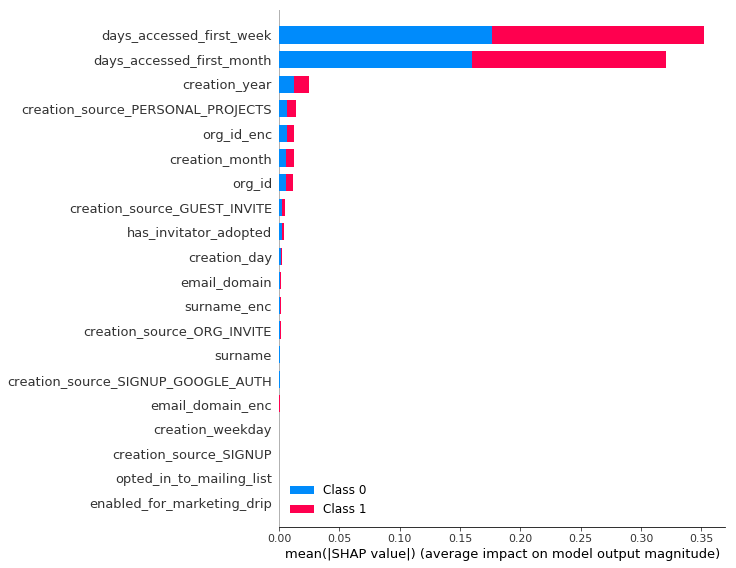

In [65]:
shap.summary_plot(shap_values_RF_test, X2_test)

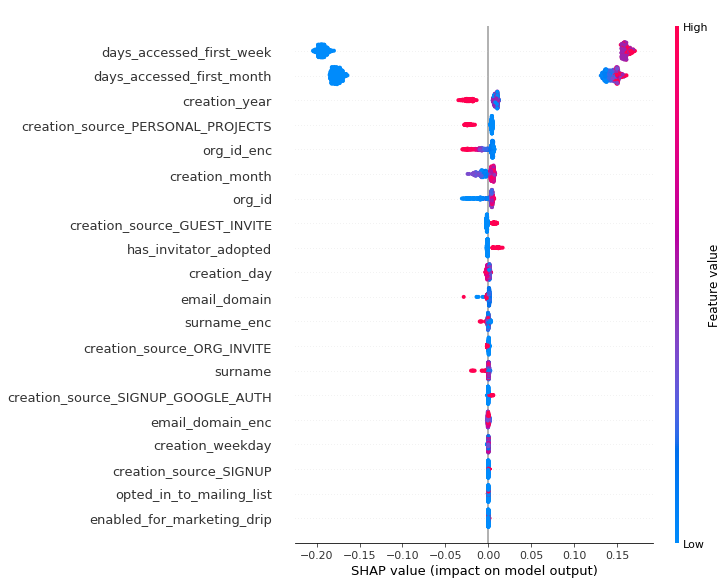

In [66]:
shap.summary_plot(shap_values_RF_test[1], X2_test)

## Reducing the number of features

In [0]:
columns_to_drop = ['days_accessed_first_3_months', 
       'days_accessed_first_6_months', 'days_from_creation_to_last_session',
       'days_accessed_first_month', 'days_accessed_first_week' ]
X3 = X.drop(columns_to_drop, axis=1)

In [0]:
X3_train, X3_test, y3_train, y3_test = train_test_split(
                                    X3, y, test_size=0.2, random_state=101)

In [69]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 101)
# Train the model on training data
parameters = { 'max_depth' : [3, 5, 8, 10]}
metric = 'accuracy'
clf = GridSearchCV(rf, parameters, scoring = metric, cv=5)
clf.fit(X3_train, y3_train)
clf_best = clf.best_estimator_ 
score = accuracy_score(clf_best.predict(X3_test), y3_test)
score_train = accuracy_score(clf_best.predict(X3_train), y3_train)
best_max_depth_grid = clf.best_params_['max_depth']
print('Best max_depth: {}, resulted score: {} for the held-out test data and {} for the train set'.format(best_max_depth_grid, score, score_train))


Best max_depth: 10, resulted score: 0.6009389671361502 for the held-out test data and 0.9197651663405088 for the train set


In [70]:
print('Accuracy: {:.3f}%'.format(score*100.0))
y3_pred = clf_best.predict(X3_test)
print('F1 Score: {:.3f}%'.format(f1_score(y3_test, y3_pred)*100))
print('Precision Score: {:.3f}%'.format(precision_score(y3_test, y3_pred)*100))
print('Recall Score: {:.3f}%'.format(recall_score(y3_test, y3_pred)*100))

Accuracy: 60.094%
F1 Score: 61.305%
Precision Score: 56.901%
Recall Score: 66.447%


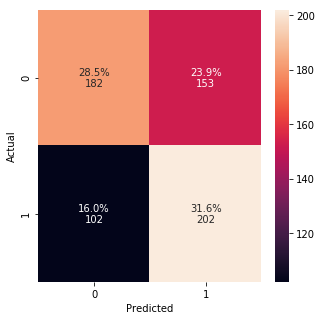

In [71]:
cm_analysis(y3_test, y3_pred, clf_best.classes_, ymap=None, figsize=(5,5))

In [0]:
explainerRF = shap.TreeExplainer(clf_best)
shap_values_RF_test = explainerRF.shap_values(X3_test)

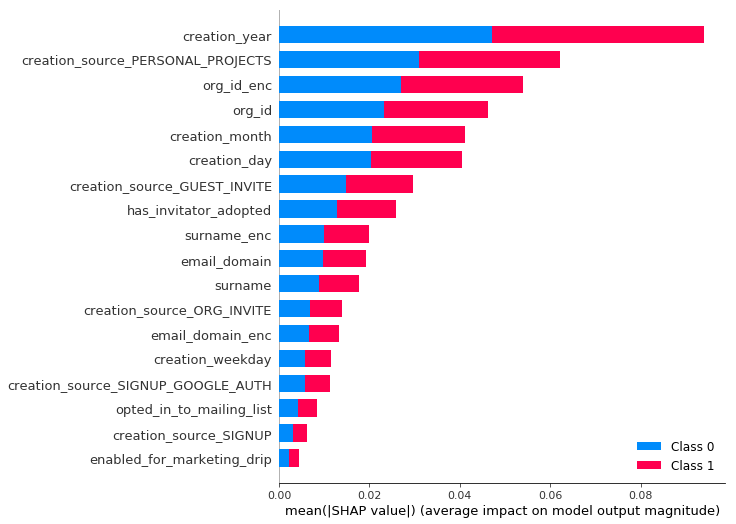

In [75]:
shap.summary_plot(shap_values_RF_test, X3_test)

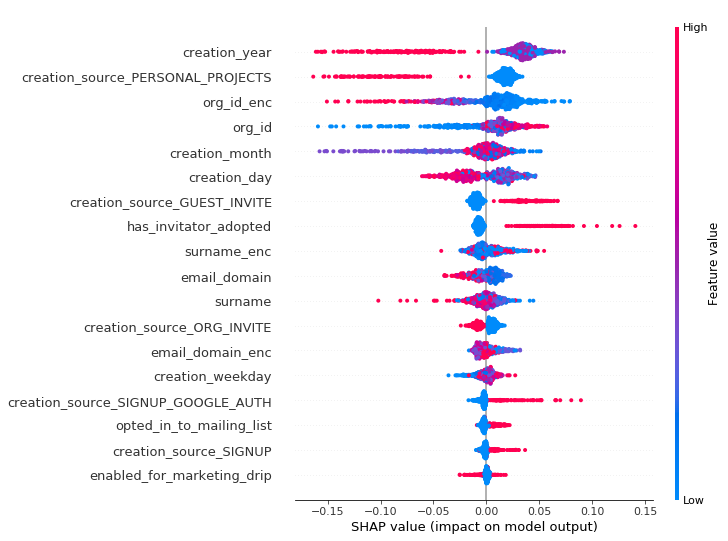

In [76]:
shap.summary_plot(shap_values_RF_test[1], X3_test)

# Final Conclusions

We started solving this case by determining which users had adopted the services. We created a feature named 'adopted' for those who had logged into the product on three separate days in at least one seven­-day period

Before running models we conducted some feature engineering creating the following features:
- number of days accessed in the first week after account creation
- In the same way we counted the number of days accessed in the first month, 3 months and 6 months
- We calculated the number of days between the creation date and the last day of access
- From the creation date, we extracted separated features for year, month, year, day and day of the week
- For those customer that were invited by another existing customer, we created a feature to identify if that customer is active
- From email data, we extracted the email domain (e.g. yahooo.com)
- From names, we extracted surnames

We did some feature preprocessing:
- for categorical features like org_id, surname and email_domain, we encoded each feature and also created new columns using frequency encoding
- we applied one-hot encoding to creation_source

To analyze feature importance we ran a binary classification model. Since the dataset is very unbalanced, we conducted a downsampling of the majority class (adopter = 0). We separated the dataset into a train and test set with hold-out validation. Then we ran a random forest model, calculate main scores, and confusion matrix. We also analyzed feature importance using shap. We gradually decreased the number of features in the model, to check their overall influence on results.

1. The first model we ran, had a very high accuracy (98.1%), but had caveats; it was too much dependable on variables that would take a lot of time to be ready to be used, such as "number of days accessed in the first 6 months" and "numbers of days between last access and creation date". This make the model not pratical, since such variables are almost data leakage for what we want to predict

2. We removed most of variables related to access, keeping only "days accessed in the first week". We got pretty good accurancy of (96.6%). The feature related to days accesssed is still by far the most important one.

3. We also conducted a last model without "days accessed in the first week". In this case, accuracy is very low (60%) just slightly better than a dummy predictor. So, no variable in this last model is a very good predictor, but the ones with some predicion power are: creation_date (year, month and daY), creation_source and org_id.

Therefore, we concluded that extracting data of usage in the first days after signing up to the product was very important to predict the customer adoption.
